# GHCN Homogenized Data - Code to analyze Volatility of Daily Max Temperature 

## 1: Import Libraries

In [6]:
import netCDF4 as nc
import numpy as np
import h5py
import os
import glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from datetime import datetime
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
import pymannkendall as mk
import scipy 
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
from scipy import stats
import datetime as dt
import calendar
import math


%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

## 2: Import data

In [7]:
os.chdir('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/GHCN_Homogenized')

filename = 'homogenized_tmin_tmax.nc'
ds = nc.Dataset(filename)
data = ds['Tmax'][:]
data = np.transpose(data)
data = data[18263:43830,:]    
stationinfo = pd.read_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/GHCN_Homogenized/stationInfo.csv')
data = pd.DataFrame(data, columns= stationinfo['stationID'])
timeinfo = pd.read_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/GHCN_Homogenized/timeInfo.csv')
timeinfo = timeinfo[18263:43830]
timeinfo= timeinfo[['time', 'year', 'month']]
timeinfo.index = list(range(timeinfo.shape[0]))
data = pd.concat([timeinfo, data], axis= 1)

## 3: Compute Volatility, timing and directionality

In [8]:
volatility_raw = data.iloc[1:,3:].to_numpy() - data.iloc[:-1,3:].to_numpy()
volatility_raw = pd.DataFrame(volatility_raw, columns= data.columns[3:])
timeinfo_new = timeinfo['time']
timeinfo_new.index = list(range(timeinfo_new.shape[0]))
volatility_raw = pd.concat([timeinfo_new, volatility_raw], axis= 1)
year_t = data['year'].iloc[1:]
year_t.index = range(len(year_t))
volatility_raw = pd.concat([year_t, volatility_raw], axis= 1)

volatility_abs = abs(data.iloc[1:,3:].to_numpy() - data.iloc[:-1,3:].to_numpy())
volatility_abs = pd.DataFrame(volatility_abs, columns= data.columns[3:])
volatility_abs = pd.concat([timeinfo_new, volatility_abs], axis= 1)
year_t = data['year'].iloc[1:]
year_t.index = range(len(year_t))
volatility_abs = pd.concat([year_t, volatility_abs], axis= 1)

In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

years= np.arange(1950, 2020)
volatility_95p= pd.DataFrame(index= years, columns= data.columns[3:])
volatility_dir= pd.DataFrame(index= years, columns= data.columns[3:])

for i in range(len(years)):
    dummy = volatility_abs[volatility_abs['year']==years[i]]
    dummy = dummy.iloc[:,2:]
    missing = np.sum(dummy.isna(), axis= 0)
    # Exclude from calculations all stations that have more than 18 days (5%) of missing data for that specific year
    dummy = dummy.iloc[:, pd.Series(missing < 18).values]
    volatility_95p.iloc[i, pd.Series(missing < 18).values] = np.nanpercentile(dummy.to_numpy(), 95, axis= 0).flatten()
    dummy.index = list(range(len(dummy)))

    dummy = volatility_raw[volatility_raw['year']==years[i]]
    dummy = dummy.iloc[:,2:]
    missing = np.sum(dummy.isna(), axis= 0)
    # Exclude from calculations all stations that have more than 18 days (5%) of missing data for that specific year
    dummy = dummy.iloc[:, pd.Series(missing < 18).values]
    d = pd.DataFrame(index= list(range(math.ceil(len(dummy)/20))), columns= dummy.columns)
    for j in range(dummy.shape[1]):
        x = dummy.iloc[:,j]
        y = x[abs(x) > np.nanpercentile(abs(x).to_numpy(), 95)]
        d.iloc[0:len(y),j] = y
        
    volatility_dir.iloc[i,pd.Series(missing < 18).values] = np.sum(d > 0, axis=0)/d.shape[0]

# Keep only stations that have at least 50 years of data or more (i.e. missing < 20)
missing = np.sum(volatility_95p.isna(), axis=0)
volatility_95p = volatility_95p.iloc[:, pd.Series(missing < 20).values]
#julian_day = julian_day.iloc[:, pd.Series(missing < 20).values]
volatility_dir = volatility_dir.iloc[:, pd.Series(missing < 20).values]

In [10]:
volatility_abs['day'] = np.nan
volatility_abs['month'] = np.nan

for i in range(len(volatility_abs)):
    volatility_abs['month'].iloc[i] = datetime.strptime(volatility_abs.time.iloc[i], '%Y-%m-%d').month
    volatility_abs['day'].iloc[i] = datetime.strptime(volatility_abs.time.iloc[i], '%Y-%m-%d').day
    
dummy = volatility_abs.iloc[:,1:].groupby(['month','day']).mean()
dummy = dummy[dummy.columns.intersection(volatility_95p.columns)]
dummy.index = list(range(dummy.shape[0]))
julian_day = dummy.idxmax(axis=0)
julian_day = pd.DataFrame(julian_day)
julian_day['stationID'] = julian_day.index
julian_day = julian_day.rename(columns={0: "julian_day"})

stations = pd.read_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/GHCN_Homogenized/stationInfo.csv')
stations[stations['stationID'].isin(julian_day.index)]
julian_day = julian_day.merge(stations, on='stationID')

## 4: Save results dataframes

In [38]:
# This dataframe contains the 95th percentile value of volatility in daily maximum temperature for each year (1950 - 2019)
# Size of data frame is 70 years * 1484 stations
volatility_95p.to_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/GHCN_Homogenized_volatility_95p.csv')
# This dataframe contains the percentage of the top 5% volatilities greater than 0 (positive) for each year (1950 - 2019)
# Size of data frame is 70 years * 1484 stations
volatility_dir.to_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/GHCN_Homogenized_volatility_dir.csv')
# This dataframe contains the julian day of max volatility for each year (1950 - 2019)
# Size of data frame is 70 years * 1484 stations
julian_day.to_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/GHCN_Homogenized_julian_day.csv')

## 5: Figure S2a: Climatology in Volatility

In [11]:
#volatility_95p = pd.read_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/GHCN_Homogenized_volatility_95p.csv')
stationinfo = pd.read_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/GHCN_Homogenized/stationInfo.csv')
stationinfo = stationinfo.iloc[pd.Series(missing < 20).values, :]
data = stationinfo
data['v'] = np.nan
data['v'] = np.nanmean(volatility_95p, axis=0)

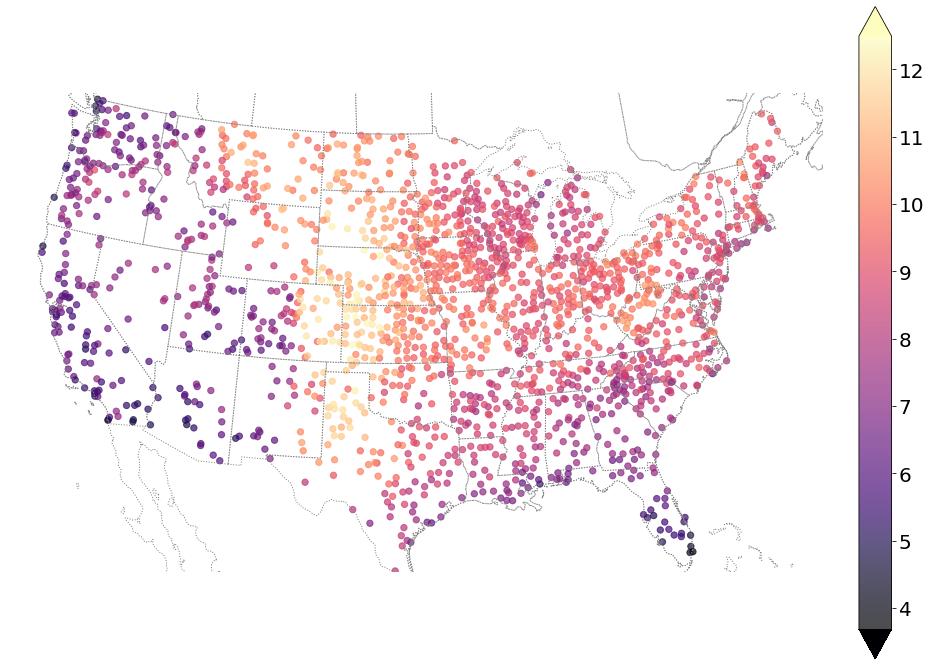

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')

ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

plot = plt.scatter(x=data.longitude, y=data.latitude, c=data['v'], cmap='magma'
            ,s=40,alpha=0.7,transform=crs.PlateCarree(), vmin= np.min(data['v']), vmax= np.max(data['v'])) 

font = {'family':'serif','weight':'bold', 'size': 16}

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both')
cbar.ax.tick_params(labelsize=20) 

plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/GHCN-Homogenized_Climatology_Volatility95p_1950_2019.jpeg'
            ,dpi=600)

plt.show()

## 6: Figure S2b: Seasonality of volatility map

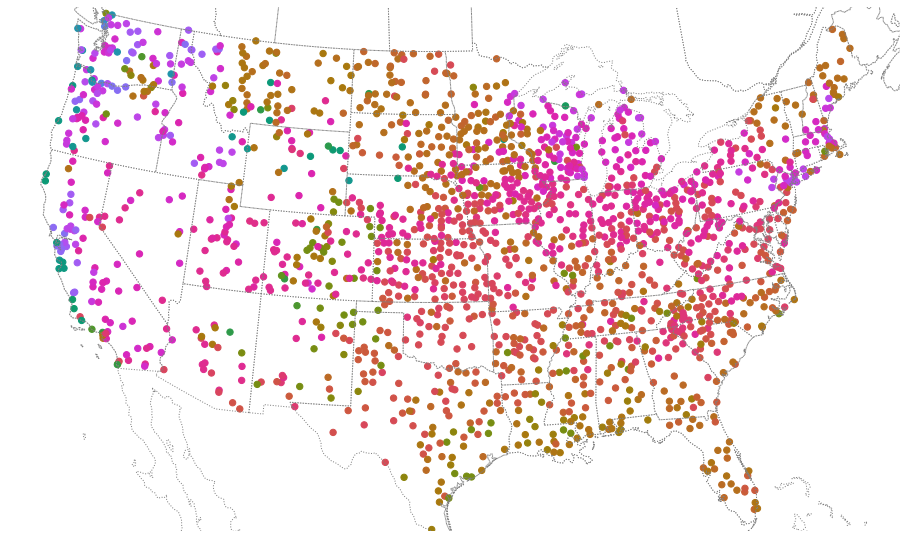

In [44]:
data = pd.read_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/GHCN_Homogenized_julian_day.csv')

from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

plot = plt.scatter(x=data.longitude, y=data.latitude, c=data['julian_day'], transform=crs.PlateCarree(), 
                s= 40, cmap= cmocean.cm.phase)

font = {'family':'serif','weight':'bold', 'size': 16}

#cbar= plt.colorbar(plot,fraction=0.046, pad=0.04)

plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/GHCN-Homogenized_Seasonality_Volatility.jpeg',dpi=600)


plt.show()

## 7: Figure S2c: Directionality of volatility

In [60]:
data = pd.DataFrame(np.nanmean(volatility_dir, axis= 0))
data['stationID'] = volatility_dir.columns
data = data.rename(columns={0: "dir"})
data['dir'] = 1 - data['dir'] 
stations = pd.read_csv('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/GHCN_Homogenized/stationInfo.csv')
stations[stations['stationID'].isin(julian_day.index)]
data = data.merge(stations, on='stationID')

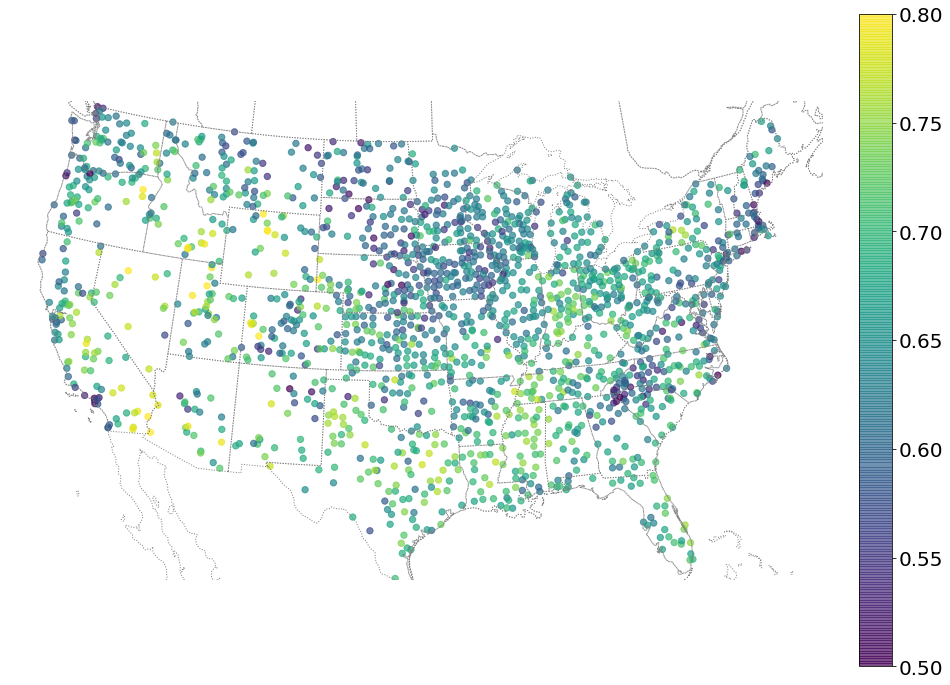

In [59]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')

ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

plot = plt.scatter(x=data.longitude, y=data.latitude, c= data['dir'], cmap='viridis'
            ,s=40,alpha=0.7,transform=crs.PlateCarree(), vmin= 0.5, vmax= 0.8) 

font = {'family':'serif','weight':'bold', 'size': 16}

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=20) 

plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/GHCN-Homogenized_Climatology_Volatilitydir_1950_2019.jpeg'
            ,dpi=600)

plt.show()

## 8: Trend analysis of volatility

In [61]:
data['slope'] = np.nan
data['p-value'] = np.nan

for s in range(data.shape[0]):
    x = volatility_95p.iloc[:,s]
    result = mk.original_test(x)
    data['p-value'].iloc[s] = result.p
    data['slope'].iloc[s] = result.slope

In [62]:
x = np.sort(data['p-value'])
y = (np.arange(1, len(x)+1)/len(x))*0.05
alpha_new = max(x[x<y])
alpha_new

0.0187171038623557

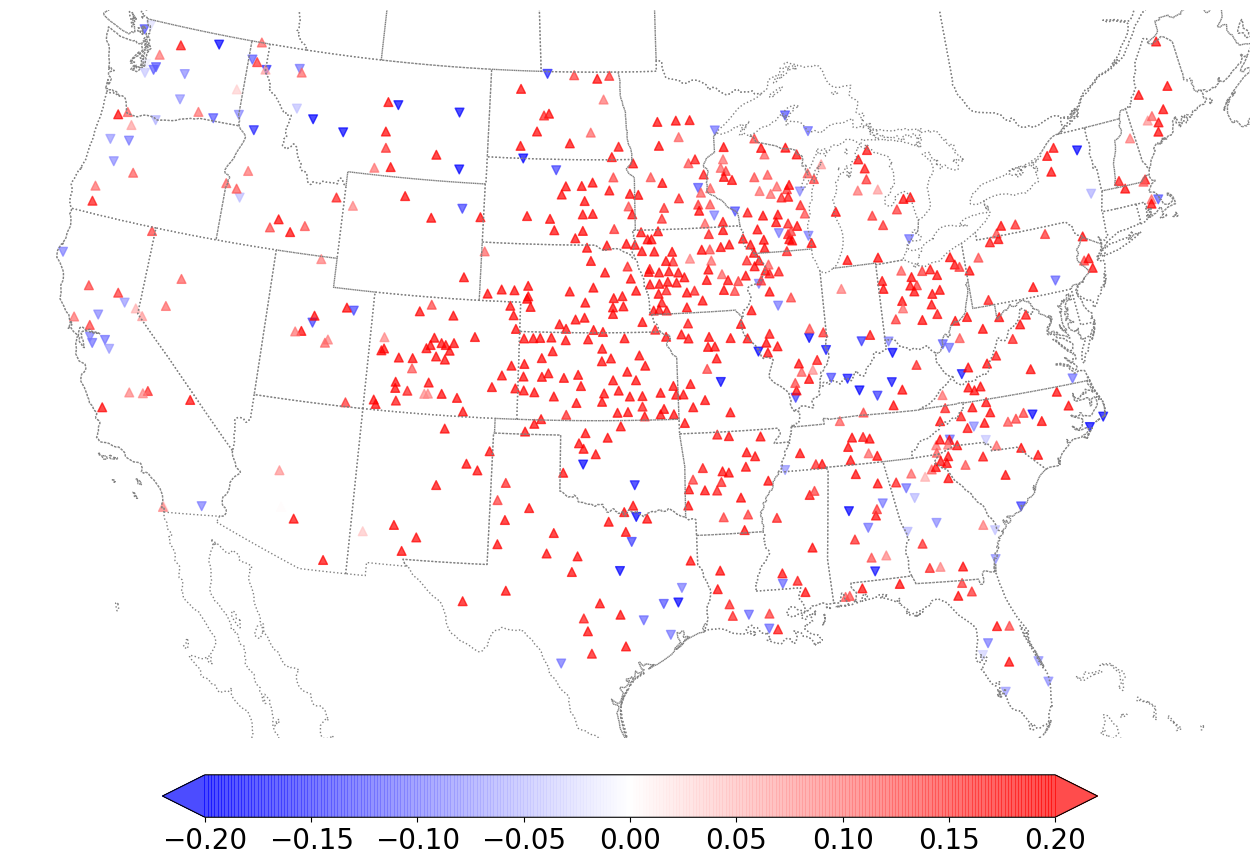

In [66]:
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

plt.rcParams.update(plt.rcParamsDefault)

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

d = data[(data['p-value'] <= alpha_new) &  (data['slope'] < 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, c=d['slope']*10,cmap = 'bwr', transform=crs.PlateCarree(), 
                alpha= 0.7, s= 40, marker= 'v', vmin = -0.2, vmax = 0.2)

d = data[(data['p-value'] <= alpha_new) &  (data['slope'] > 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, c=d['slope']*10,cmap = 'bwr', transform=crs.PlateCarree(), 
                alpha= 0.7, s= 40, marker= '^', vmin = -0.2, vmax = 0.2)

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both', orientation= 'horizontal')
cbar.ax.tick_params(labelsize=20)


#d = data[(data['p-value'] >= 0.05)]
#plot = plt.scatter(x=d.longitude, y=d.latitude, c='gray', transform=crs.PlateCarree(), 
 #               alpha= 0.2, s= 40, marker= 'o')

#d = data[(data['p-value'] > alpha_new) & (data['slope'] < 0)]
#plot = plt.scatter(x=d.longitude, y=d.latitude, transform=crs.PlateCarree(), 
 #               alpha= 1, s= 40, marker= 'v', facecolors='none', edgecolors='b')

#d = data[(data['p-value'] > alpha_new)  & (data['slope'] > 0)]
#plot = plt.scatter(x=d.longitude, y=d.latitude, transform=crs.PlateCarree(), 
 #               alpha= 1, s= 40, marker= '^', facecolors='none', edgecolors='r')

font = {'family':'serif','weight':'bold', 'size': 16}

plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/GHCN-Homogenized_Sigtrend_map.jpeg'
            ,dpi=600)

plt.show()

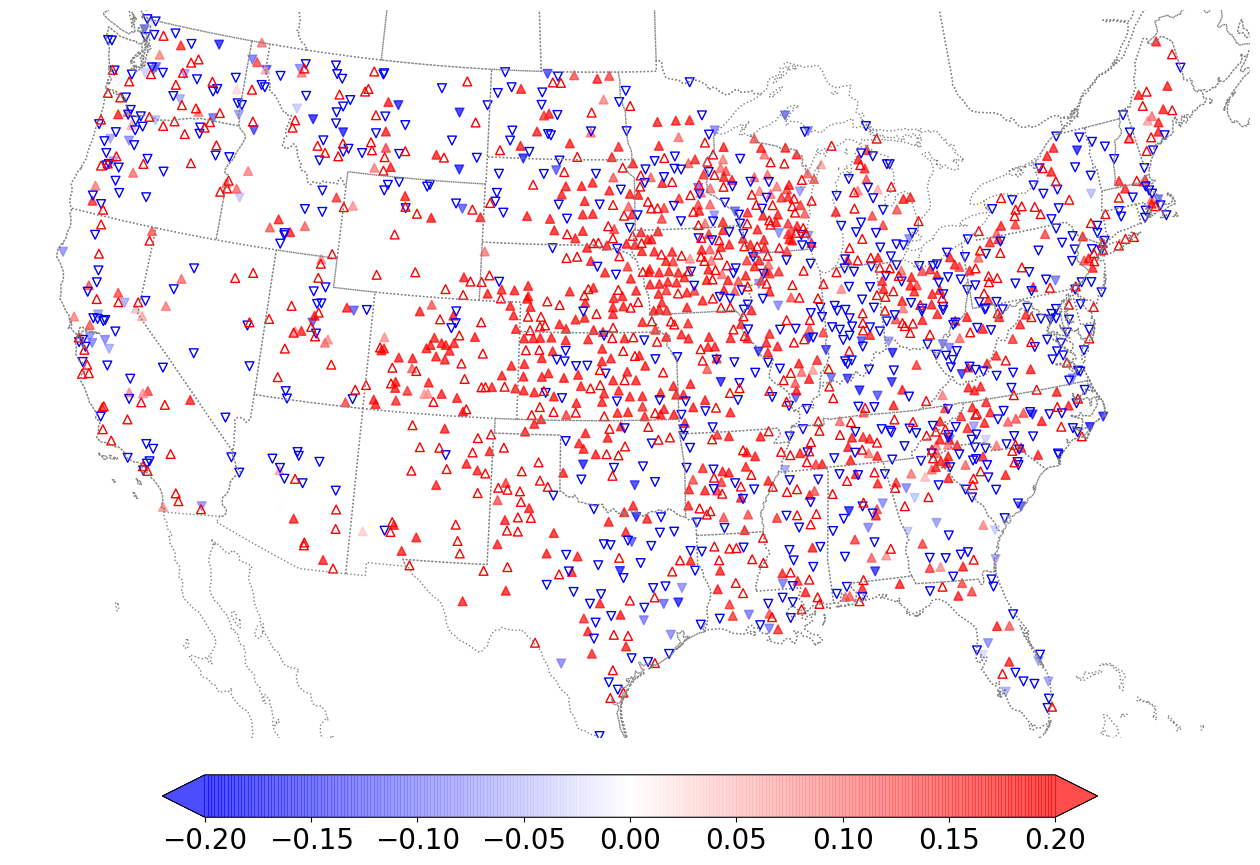

In [67]:
import cartopy
import cartopy.crs as crs
import cartopy.feature as cfeature
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

plt.rcParams.update(plt.rcParamsDefault)

figure = plt.figure(figsize=(16,12))
ax= figure.add_subplot(1,1,1, projection=crs.AlbersEqualArea(central_latitude=39.5, 
                                                             central_longitude=-98.35, globe= None))
ax.axis('off')
ax.add_feature(cfeature.COASTLINE, linestyle=':', edgecolor= 'gray')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor= 'gray')
# Zoom in on the US by setting longitude/latitude parameters
ax.set_extent([-122, -72, 26, 49],crs=crs.PlateCarree())

d = data[(data['p-value'] <= alpha_new) &  (data['slope'] < 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, c=d['slope']*10,cmap = 'bwr', transform=crs.PlateCarree(), 
                alpha= 0.7, s= 40, marker= 'v', vmin = -0.2, vmax = 0.2)

d = data[(data['p-value'] <= alpha_new) &  (data['slope'] > 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, c=d['slope']*10,cmap = 'bwr', transform=crs.PlateCarree(), 
                alpha= 0.7, s= 40, marker= '^', vmin = -0.2, vmax = 0.2)

cbar= plt.colorbar(plot,fraction=0.046, pad=0.04, extend= 'both', orientation= 'horizontal')
cbar.ax.tick_params(labelsize=20)


#d = data[(data['p-value'] >= 0.05)]
#plot = plt.scatter(x=d.longitude, y=d.latitude, c='gray', transform=crs.PlateCarree(), 
 #               alpha= 0.2, s= 40, marker= 'o')

d = data[(data['p-value'] > alpha_new) & (data['slope'] < 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, transform=crs.PlateCarree(), 
                alpha= 1, s= 40, marker= 'v', facecolors='none', edgecolors='b')

d = data[(data['p-value'] > alpha_new)  & (data['slope'] > 0)]
plot = plt.scatter(x=d.longitude, y=d.latitude, transform=crs.PlateCarree(), 
                alpha= 1, s= 40, marker= '^', facecolors='none', edgecolors='r')

font = {'family':'serif','weight':'bold', 'size': 16}

plt.savefig('/Users/ombadi/Desktop/LBNL/CASCADE/Volatility/Results/Figures/GHCN-Homogenized_Alltrend_map.jpeg'
            ,dpi=600)

plt.show()